In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from target_encoding import TargetEncoderClassifier, TargetEncoder
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import cross_val_score
import json
from functools import partial
from dsb2019.models.coeff import ThresholdClassifier

from dsb2019.models.tracking import track_experiment, track_submission_info
from dsb2019.data.validation import InstallationFold, cross_validate, quad_kappa
from dsb2019.visualization import session_browser
from dsb2019.data import DATA_DIR
from dsb2019.data import adv_validation
from dsb2019.models import MODELS_DIR
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import hyperopt
from hyperopt import hp, fmin, Trials, tpe, STATUS_OK
from multiprocessing import cpu_count
from joblib import Parallel, delayed

tqdm.pandas()
pd.options.display.max_rows=999

In [3]:
train = pd.read_csv(DATA_DIR / 'raw/train.csv')
test = pd.read_csv(DATA_DIR / 'raw/test.csv')
train_labels = pd.read_csv(DATA_DIR / 'raw/train_labels.csv')
submission = pd.read_csv(DATA_DIR / 'raw/sample_submission.csv')

In [4]:
games = ['Scrub-A-Dub', 'All Star Sorting',
       'Air Show', 'Crystals Rule', 
       'Dino Drink', 'Bubble Bath', 'Dino Dive', 'Chow Time',
       'Pan Balance', 'Happy Camel',
       'Leaf Leader']
assessments = ['Mushroom Sorter (Assessment)',
       'Bird Measurer (Assessment)',
       'Cauldron Filler (Assessment)',
       'Cart Balancer (Assessment)', 'Chest Sorter (Assessment)']
worlds = ['NONE', 'MAGMAPEAK', 'TREETOPCITY', 'CRYSTALCAVES']

def unwrap_event_data(df):
    unwrapped=pd.DataFrame(data=list(df.event_data.apply(json.loads).values))
    unwrapped.drop("event_code", axis=1, inplace=True)
    return pd.concat([unwrapped.reset_index(),df.reset_index()],axis=1)


event_data_features = ["duration", "round", "level", "position", "total_duration", "weight", "misses"]


def extract_basic_stats(df):
    stats = ["min", "max", "mean", "std"]
    df = df[[f for f in event_data_features if f in df.columns]].reindex(columns=event_data_features)
    result = []
    for column, stats in df.agg(stats).to_dict().items():
        result.extend([(k+"_"+column, v) for k,v in stats.items()])
    return result


def extract_chow_time(df):
    cols = ["round", "event_id", "resources", "target_weight", "game_session"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="63f13dd7"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({"optimum":None, "complete": 0})
        resources = data["resources"]
        target = data["target_weight"]
        optimum = 0
        cnt = 0
        for v in sorted(resources)[::-1]:
            if v+cnt>target:
                continue
            else:
                cnt+=v
                optimum+=1
                if cnt==target:
                    break
        n_turns = sum(df.event_id=="4ef8cdd3")
        complete = sum(df.event_id=="56817e2b")
        return pd.Series({"optimum":n_turns / optimum, "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("chowtime_optimum", None), ("chowtime_complete", None)]
    return [("chowtime_optimum", feature["optimum"]), ("chowtime_complete", feature["complete"])]


def extract_leaf_leader(df):
    cols = ["round", "event_id", "target_weight", "game_session"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="f32856e4"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({"optimum": None, "complete": 0})
        target = data["target_weight"]
        optimum = 0
        cnt = 0
        for v in [4, 4, 2, 2, 2, 2, 1, 1]:
            if v+cnt>target:
                continue
            else:
                cnt+=v
                optimum+=1
                if cnt==target:
                    break
        n_turns = sum(df.event_id=="262136f4")
        complete = sum(df.event_id=="b012cd7f")
        return pd.Series({"optimum": n_turns / optimum, "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("leafleader_optimum", None), ("leafleader_complete", None)]
    return [("leafleader_optimum", feature["optimum"]), ("leafleader_complete", feature["complete"])]


def extract_happy_camel(df):
    cols = ["round", "event_id", "has_toy", "bowls", "game_session"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="c2baf0bd"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({'optimum':None, 'n_toy_detected':None, "complete":0})
    
    ~.optimum = len(data["bowls"])
        turns = df[df.event_id=="6bf9e3e1"]
        n_turns = len(turns)
        n_toy_detected = turns["has_toy"].sum()
        complete = sum(df.event_id=="36fa3ebe")
        return pd.Series({'optimum':(n_turns / optimum), 'n_toy_detected':n_toy_detected, "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("happycamel_optimum", None), ("happycamel_detections", None), 
                ("happycamel_complete", None)]

    return [("happycamel_optimum", feature["optimum"]), ("happycamel_detections", feature["n_toy_detected"]), 
            ("happycamel_complete", feature["complete"])]


def extract_pan_balance(df):
    cols = ["round", "event_id", "target_weight", "starting_weights", "game_session"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="a592d54e"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({"optimum": None, "complete": 0})
        target = data["target_weight"]
        start = data["starting_weights"]
        optimum = max(abs(target - start), 1)
        n_turns = sum(df.event_id.isin(("e7561dd2", "804ee27f")))
        complete = sum(df.event_id=="1c178d24")
        return pd.Series({"optimum": n_turns / optimum, "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("panbalance_optimum", None), ("panbalance_complete", None)] 
    return [("panbalance_optimum", feature["optimum"]), ("panbalance_complete", feature["complete"])]


def extract_scrubadub(df):
    cols = ["round", "event_id", "game_session", "correct", "event_code", "animals"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="26fd2d99"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({"performance":None, "precision": None, "complete": 0})
        n_animals = len(data["animals"])
        complete = sum(df.event_id=="08fd73f3")
        df = df[(df.event_id=="5c3d2b2f")&(df.event_code==4020)]
        return pd.Series({"performance": len(df) / n_animals, "precision": df["correct"].sum()/n_animals, "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("scrubadub_performance", None), ("scrubadub_precision", None), ("scrubadub_complete", None)]
    return [("scrubadub_performance", feature["performance"]), ("scrubadub_precision", feature["precision"]),
            ("scrubadub_complete", feature["complete"])]    


def extract_allstarsorting(df):
    cols = ["round", "event_id", "game_session", "correct", "event_code", "houses"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="2c4e6db0"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({"performance":None, "precision": None, "complete": 0})
        n_animals = len(data["houses"])
        complete = sum(df.event_id=="ca11f653")
        df = df[df.event_id=="2dc29e21"]
        return pd.Series({"performance": len(df) / n_animals, "precision": df["correct"].sum()/n_animals, "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("allstarsorting_performance", None), ("allstarsorting_precision", None), ("allstarsorting_complete", None)]
    return [("allstarsorting_performance", feature["performance"]), ("allstarsorting_precision", feature["precision"]),
            ("allstarsorting_complete", feature["complete"])]  


def extract_dinodrink(df):
    cols = ["round", "event_id", "game_session", "correct", "event_code", "holes"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="f806dc10"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({"performance": None, "precision": None, "complete": 0})
        n_animals = len(data["holes"])
        complete = sum(df.event_id=="16dffff1")
        df = df[df.event_id=="74e5f8a7"]
        return pd.Series({"performance": len(df) / n_animals, "precision": df["correct"].sum()/n_animals, "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("dinodrink_performance", None), ("dinodrink_precision", None), ("dinodrink_complete", None)]
    return [("dinodrink_performance", feature["performance"]), ("dinodrink_precision", feature["precision"]),
            ("dinodrink_complete", feature["complete"])]  


def extract_bubblebath(df):
    cols = ["round", "event_id", "game_session", "containers", "target_containers"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="1beb320a"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({"performance": None, "complete": 0})
        target = data["target_containers"]
        complete = sum(df.event_id=="895865f3")
        df = df[df.event_id=="3bb91dda"]
        if len(df):
            return pd.Series({"performance": abs(target - df.iloc[0]["containers"]), "complete": complete})
        else:
            return pd.Series({"performance": None, "complete": 0})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if isinstance(feature, pd.Series):
        return [("bubblebath_performance", None), ("bubblebath_complete", None)]
    return [("bubblebath_performance", feature["performance"]), ("bubblebath_complete", feature["complete"])] 


def extract_dinodive(df):
    cols = ["round", "event_id", "game_session", "correct", "target_water_level"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        data = df[df.event_id=="7961e599"]
        if len(data):
            data=data.iloc[0]
        else:
            return pd.Series({"performance": None, "precision": None, "complete": 0})
        target = data["target_water_level"]
        dinos = [6, 6, 3, 3, 3, 3, 1, 1]
        opt=0
        n_animals=0
        for d in dinos:
            if opt+d>target:
                continue
            else:
                opt+=d
                n_animals+=1
                if opt==target:
                    break
        complete = sum(df.event_id=="00c73085")
        df = df[df.event_id=="c0415e5c"]
        return pd.Series({"performance": len(df) / n_animals, "precision": df["correct"].sum()/n_animals, "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("dinodive_performance", None), ("dinodive_precision", None), ("dinodive_complete", None)]
    return [("dinodive_performance", feature["performance"]), ("dinodive_precision", feature["precision"]),
            ("dinodive_complete", feature["complete"])]


def extract_airshow(df):
    cols = ["round", "event_id", "game_session", "correct"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        complete =sum(df.event_id=="f5b8c21a")
        df = df[df.event_id=="28f975ea"]
        return pd.Series({"performance": len(df), "precision": df["correct"].sum(), "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("airshow_performance", None), ("airshow_precision", None), ("airshow_complete", None)]
    return [("airshow_performance", feature["performance"]), ("airshow_precision", feature["precision"]),
            ("airshow_complete", feature["complete"])]      


def extract_crystalsrule(df):
    cols = ["round", "event_id", "game_session", "correct"]
    df = df[[c for c in cols if c in df.columns]]
    df = df.reindex(columns=cols)
    df = df[df["round"]>0]
    
    def calculate_features(df):
        complete = sum(df.event_id=="3323d7e9")
        df = df[df.event_id=="86c924c4"]
        return pd.Series({"performance": len(df), "precision": df["correct"].sum(), "complete": complete})
    feature =  df.groupby(["game_session", "round"]).apply(calculate_features).mean()
    if len(feature)==0:
        return [("crystalsrule_performance", None), ("crystalsrule_precision", None), ("crystalsrule_complete", None)]
    return [("crystalsrule_performance", feature["performance"]), ("crystalsrule_precision", feature["precision"]),
            ("crystalsrule_complete", feature["complete"])]          


game_funcs={
    "Chow Time": extract_chow_time,
    "Leaf Leader": extract_leaf_leader,
    "Happy Camel": extract_happy_camel,
    "Pan Balance": extract_pan_balance,
    "Scrub-A-Dub": extract_scrubadub,
    "All Star Sorting": extract_allstarsorting,
    "Dino Drink": extract_dinodrink,
    "Bubble Bath": extract_bubblebath,
    "Dino Dive": extract_dinodive,
    "Air Show": extract_airshow,
    "Crystals Rule": extract_crystalsrule,
}


def extract_game_stats(df, title):
    return game_funcs[title](df)


def make_counters(df, column):
    return {k: v for k, v in df.groupby(column)[column].count().to_dict().items()}

    
def process_log(df):
    assessment_title=df.title.iloc[-1]   
    world=df.world.iloc[-1]

    history = df.iloc[:-1]
    history = history[history.type.isin(["Game", "Assessment"])].copy()

    def calculate_ratios(df):
        n_correct=df.correct_move.sum()
        n_incorrect=df.wrong_move.sum()
        ratio=n_correct/(n_correct+n_incorrect)
        return n_correct, n_incorrect, ratio
    
    def make_move_stats(df, title,n_lags=2):
        df=df.copy()
        if len(df):
            df = unwrap_event_data(df)
        if "correct" in df.columns:
            df["correct_move"] = df.correct == True
            df["wrong_move"] = df.correct == False
        else:
            df["correct_move"]=False
            df["wrong_move"]=False
        result = []
        result.extend(zip([f"n_correct_{title}", f"n_incorrect_{title}", f"global_ratio_{title}"], calculate_ratios(df)))
        result.extend(extract_game_stats(df, title))
        #result.extend(extract_basic_stats(df))
        if n_lags:
            last_sessions = df.game_session.unique()[-n_lags:]
            for i in range(n_lags):
                if i < len(last_sessions): 
                    result.extend(zip([f"n_correct_{title}_{i}", f"n_incorrect_{title} {i}",f"ratio_{title}_{i}"], 
                                      calculate_ratios(df[df.game_session==last_sessions[i]])))
                else:
                    result.extend(zip([f"n_correct_{title}_{i}", f"n_incorrect_{title}_{i}",f"ratio_{title}_{i}"], [None, None, None]))
        return {k: v for k, v in result}
    
    
    result = {"title": assessments.index(assessment_title),
              "world": worlds.index(world),
              "n_activities": df[df.type=="Activity"].game_session.nunique(),
              "n_games": df[df.type=="Game"].game_session.nunique(),
              "event_code_count": df.event_code.nunique(),
              "event_id_count": df.event_id.nunique(),
              "title_count": df.title.nunique(),
              "n_actions": len(df),
              "world_title_count": df[df.world==world].title.nunique(),
             }
    
    def make_game_features(game):
        result = {}
        stats=history[history.title==game]
        stats_features=make_move_stats(stats, game)
        stats_features[f"{game}_event_code_count"] = stats.event_code.nunique()
        stats_features[f"{game}_event_id_count"] = stats.event_id.nunique()
        stats_features[f"{game}_session_id_count"] = stats.game_session.nunique()
        stats_features[f"{game}_n_actions"] = len(stats)
        result.update(stats_features)
        result.update({f"{game}_{k}": v for k, v in make_counters(stats, "event_id").items()})
        result.update({f"{game}_{k}": v for k, v in make_counters(stats, "event_code").items()})
        return result
    
    for f in Parallel(n_jobs=cpu_count())(delayed(make_game_features)(game) for game in games):
        result.update(f)
    #for game in games:
    #    result.update(make_game_features(game))
    world_games = history[history.world==world]
    
    def make_world_features(game):
        result = {}
        stats=world_games[world_games.title==game]
        stats_features=make_move_stats(stats, game)
        stats_features = {f"world_{k}": v for k, v in stats_features.items()}
        stats_features[f"world_{game}_event_code_count"] = stats.event_code.nunique()
        stats_features[f"world_{game}_event_id_count"] = stats.event_id.nunique()
        stats_features[f"world_{game}_session_id_count"] = stats.game_session.nunique()
        stats_features[f"world_{game}_n_actions"] = len(stats)
        result.update(stats_features)
        result.update({f"world_{game}_{k}": v for k, v in make_counters(stats, "event_id").items()})
        result.update({f"world_{game}_{k}": v for k, v in make_counters(stats, "event_code").items()})
        return result
    
    for f in Parallel(n_jobs=cpu_count())(delayed(make_world_features)(game) for game in games):
        result.update(f)
    #for game in games:
    #    result.update(make_world_features(game))
    make_history_counters = partial(make_counters, history)
    result.update(make_counters(history, "event_id"))
    result.update(make_counters(history, "event_code"))
    return result

In [ ]:
def process_installations(train_labels, train, process_log):
    result = []
    train=train.sort_values("timestamp")
    installations = train.groupby("installation_id")
    for i, game_session, title, installation_id, accuracy_group in tqdm(train_labels[["game_session", "title", "installation_id", "accuracy_group"]].itertuples(), 
                                                              total=len(train_labels), position=0):
        player_log = installations.get_group(installation_id).reset_index()
        player_log = player_log.sort_values("timestamp")
        log_length = player_log[(player_log.game_session==game_session) & (player_log.title==title)].index[0]
        player_log = player_log.iloc[:(log_length + 1)]
        player_log["accuracy_group"] = accuracy_group
        player_log["target_game_session"] = game_session
        features = process_log(player_log)
        features["installation_id"] = installation_id
        features["accuracy_group"] = accuracy_group
        result.append(features)
    return pd.DataFrame(data=result).fillna(-1)

In [5]:
train_features = process_installations(train_labels, train, process_log)

100%|██████████| 17690/17690 [2:24:46<00:00,  2.04it/s]  


In [6]:
#np.corrcoef(train_features["airshow_precision"], train_features["world_airshow_precision"])[0][1]

In [7]:
#train_features[[c for c in train_features.columns if isinstance(c, str) and ("crystalsrule" in c)]]

In [8]:
bad_features = ["session_id_count", "event_id_count", "mean_round", "n_actions", "n_activities"]

In [9]:
def get_duplicate_features(features, bad_features):
    to_remove = set([])
    counter = 0
    feature_names=[f for f in features.columns if f not in ("installation_id", "game_session", "accuracy_group")]
    for feat_a in tqdm(feature_names):
        for feat_b in feature_names:
            if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
                c = np.corrcoef(features[feat_a], features[feat_b])[0][1]
                if c > 0.995:
                    counter += 1
                    to_remove.add(feat_b)
                    if feat_b in bad_features or feat_a in bad_features:
                        to_remove.add(feat_a)
                    #print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))
    for bf in bad_features:
        to_remove.add(bf)
    print(f"{len(to_remove)} features were removed ({round(len(to_remove)/len(feature_names)*100, 2)}% of all features)")
    return list(to_remove)
    
duplicate_features = get_duplicate_features(train_features, bad_features)

useful_features = [f for f in train_features.columns if f not in duplicate_features]
useful_features

  0%|          | 0/1542 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 1542/1542 [03:31<00:00,  7.30it/s]

800 features were removed (51.88% of all features)


['title',
 'world',
 'n_games',
 'event_code_count',
 'title_count',
 'world_title_count',
 'n_correct_Scrub-A-Dub',
 'n_incorrect_Scrub-A-Dub',
 'global_ratio_Scrub-A-Dub',
 'scrubadub_performance',
 'scrubadub_complete',
 'n_correct_Scrub-A-Dub_0',
 'n_incorrect_Scrub-A-Dub 0',
 'ratio_Scrub-A-Dub_0',
 'n_correct_Scrub-A-Dub_1',
 'n_incorrect_Scrub-A-Dub_1',
 'ratio_Scrub-A-Dub_1',
 'Scrub-A-Dub_session_id_count',
 'Scrub-A-Dub_n_actions',
 'Scrub-A-Dub_4a09ace1',
 'Scrub-A-Dub_5a848010',
 'Scrub-A-Dub_5c3d2b2f',
 'Scrub-A-Dub_6d90d394',
 'Scrub-A-Dub_7040c096',
 'Scrub-A-Dub_c1cac9a2',
 'Scrub-A-Dub_cf82af56',
 'Scrub-A-Dub_f71c4741',
 'n_correct_All Star Sorting',
 'n_incorrect_All Star Sorting',
 'global_ratio_All Star Sorting',
 'allstarsorting_performance',
 'allstarsorting_precision',
 'n_correct_All Star Sorting_0',
 'n_incorrect_All Star Sorting 0',
 'ratio_All Star Sorting_0',
 'n_correct_All Star Sorting_1',
 'n_incorrect_All Star Sorting 1',
 'ratio_All Star Sorting_1',
 'All Star Sorting_event_code_count',
 'All Star Sorting_session_id_count',
 'All Star Sorting_n_actions',
 'All Star Sorting_1cc7cfca',
 'All Star Sorting_2c4e6db0',
 'All Star Sorting_2dc29e21',
 'All Star Sorting_363d3849',
 'All Star Sorting_4b5efe37',
 'All Star Sorting_587b5989',
 'All Star Sorting_6043a2b4',
 'All Star Sorting_b120f2ac',
 'All Star Sorting_d02b7a8e',
 'n_correct_Air Show',
 'n_incorrect_Air Show',
 'global_ratio_Air Show',
 'airshow_performance',
 'airshow_precision',
 'airshow_complete',
 'n_correct_Air Show_0',
 'n_incorrect_Air Show 0',
 'ratio_Air Show_0',
 'n_correct_Air Show_1',
 'n_incorrect_Air Show_1',
 'ratio_Air Show_1',
 'Air Show_event_code_count',
 'Air Show_session_id_count',
 'Air Show_n_actions',
 'Air Show_06372577',
 'Air Show_14de4c5d',
 'Air Show_1575e76c',
 'Air Show_15ba1109',
 'Air Show_28f975ea',
 'Air Show_58a0de5c',
 'Air Show_65abac75',
 'Air Show_7423acbc',
 'Air Show_a1bbe385',
 'Air Show_bcceccc6',
 'Air Show_d88ca108',
 'Air Show_dcb55a27',
 'n_correct_Crystals Rule',
 'n_incorrect_Crystals Rule',
 'global_ratio_Crystals Rule',
 'crystalsrule_performance',
 'crystalsrule_precision',
 'n_correct_Crystals Rule_0',
 'n_incorrect_Crystals Rule 0',
 'ratio_Crystals Rule_0',
 'n_correct_Crystals Rule_1',
 'n_incorrect_Crystals Rule_1',
 'ratio_Crystals Rule_1',
 'Crystals Rule_event_code_count',
 'Crystals Rule_session_id_count',
 'Crystals Rule_n_actions',
 'Crystals Rule_44cb4907',
 'Crystals Rule_48349b14',
 'Crystals Rule_5e3ea25a',
 'Crystals Rule_86c924c4',
 'Crystals Rule_cc5087a3',
 'n_correct_Dino Drink',
 'n_incorrect_Dino Drink',
 'global_ratio_Dino Drink',
 'dinodrink_performance',
 'dinodrink_precision',
 'dinodrink_complete',
 'n_correct_Dino Drink_0',
 'n_incorrect_Dino Drink_0',
 'ratio_Dino Drink_0',
 'n_correct_Dino Drink_1',
 'n_incorrect_Dino Drink_1',
 'ratio_Dino Drink_1',
 'Dino Drink_event_code_count',
 'Dino Drink_session_id_count',
 'Dino Drink_n_actions',
 'n_correct_Bubble Bath',
 'n_incorrect_Bubble Bath',
 'global_ratio_Bubble Bath',
 'bubblebath_performance',
 'bubblebath_complete',
 'n_correct_Bubble Bath_0',
 'n_incorrect_Bubble Bath_0',
 'ratio_Bubble Bath_0',
 'n_correct_Bubble Bath_1',
 'n_incorrect_Bubble Bath_1',
 'ratio_Bubble Bath_1',
 'Bubble Bath_event_code_count',
 'Bubble Bath_session_id_count',
 'Bubble Bath_n_actions',
 'n_correct_Dino Dive',
 'n_incorrect_Dino Dive',
 'global_ratio_Dino Dive',
 'dinodive_performance',
 'dinodive_precision',
 'dinodive_complete',
 'n_correct_Dino Dive_0',
 'n_incorrect_Dino Dive_0',
 'ratio_Dino Dive_0',
 'n_correct_Dino Dive_1',
 'n_incorrect_Dino Dive_1',
 'ratio_Dino Dive_1',
 'Dino Dive_event_code_count',
 'Dino Dive_session_id_count',
 'Dino Dive_n_actions',
 'n_correct_Chow Time',
 'n_incorrect_Chow Time',
 'global_ratio_Chow Time',
 'chowtime_optimum',
 'chowtime_complete',
 'n_correct_Chow Time_0',
 'n_incorrect_Chow Time_0',
 'ratio_Chow Time_0',
 'n_correct_Chow Time_1',
 'n_incorrect_Chow Time_1',
 'ratio_Chow

In [10]:
train_features=train_features[useful_features].copy()

In [11]:
def lgb_quad_kappa(preds, true):
    true = true.get_label()
    #preds = preds.reshape((4, -1)).argmax(axis=0)
    preds = np.rint(preds)
    preds = np.maximum(0, preds)
    preds = np.minimum(3, preds)
    return "quad_kappa", quad_kappa(true, preds), True
    
    
def train_baseline(x_train,y_train, params=None):
    x_train_all, x_val_all,y_train_all,y_val_all = train_test_split(
        x_train,y_train,
        test_size=0.15,
        random_state=2019,
    )
    train_set = lgb.Dataset(x_train_all, y_train_all)
    val_set = lgb.Dataset(x_val_all, y_val_all)

#     params = {
#         'learning_rate': 0.01,
#         'bagging_fraction': 0.9,
#         'feature_fraction': 0.9,
#         'num_leaves': 14,
#         'lambda_l1': 0.1,
#         'lambda_l2': 1,
#         'metric': 'multiclass',
#         'objective': 'multiclass',
#         'num_classes': 4,
#         'random_state': 2019
#     }

    return lgb.train(params, train_set, num_boost_round=10000, early_stopping_rounds=2000, valid_sets=[val_set], verbose_eval=100)#,
                    #feval=lgb_quad_kappa)

def make_features(df):
    return df.drop(["installation_id", "accuracy_group"], axis=1), df.accuracy_group.values

def make_features_wrapper(train, test):
    def make_features(df):
        return df.drop(["installation_id", "accuracy_group"], axis=1), df.accuracy_group.values
    
    return make_features(train), make_features(test) 


def make_predictions(model,x_test_all,y_test):
    preds=model.predict(x_test_all)
    #preds = np.rint(preds)
    #preds = np.maximum(0, preds)
    #preds = np.minimum(3, preds)
    return preds,y_test

In [ ]:
def process_test_installations(test):
    test = test.sort_values("timestamp")
    test=test.groupby("installation_id").progress_apply(process_log).reset_index()
    test.columns = ["installation_id", "features"]
    result = []
    for i, installation_id, feature in test.itertuples():
        result.append(feature)
        feature["installation_id"]=installation_id
    return pd.DataFrame(result).fillna(-1)
test_features=process_test_installations(test)

for useful_feature in useful_features:
    if useful_feature not in test_features.columns:
        test_features[useful_feature]=-1
        print("Missing feature", useful_feature)

test_features=test_features[[c for c in useful_features if c != "accuracy_group"]].copy()

100%|█████████▉| 995/1000 [06:58<00:02,  2.38it/s]

In [ ]:
!ls ../dsb2019/models

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 2000 rounds
[100]	valid_0's auc: 0.688129
[200]	valid_0's auc: 0.689927
[300]	valid_0's auc: 0.689113
[400]	valid_0's auc: 0.686737
[500]	valid_0's auc: 0.682999
[600]	valid_0's auc: 0.680718
[700]	valid_0's auc: 0.677177
[800]	valid_0's auc: 0.673514
[900]	valid_0's auc: 0.671248
[1000]	valid_0's auc: 0.670535
[1100]	valid_0's auc: 0.669028
[1200]	valid_0's auc: 0.668129
[1300]	valid_0's auc: 0.667837
[1400]	valid_0's auc: 0.666903
[1500]	valid_0's auc: 0.665114
[1600]	valid_0's auc: 0.665144
[1700]	valid_0's auc: 0.664702
[1800]	valid_0's auc: 0.664753
[1900]	valid_0's auc: 0.66414
[2000]	valid_0's auc: 0.662432
[2100]	valid_0's auc: 0.661648
[2200]	valid_0's auc: 0.660894
Early stopping, best iteration is:
[231]	valid_0's auc: 0.690922
0.6817600357641077


/opt/conda/lib/python3.6/site-packages/shap/explainers/tree.py:180: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


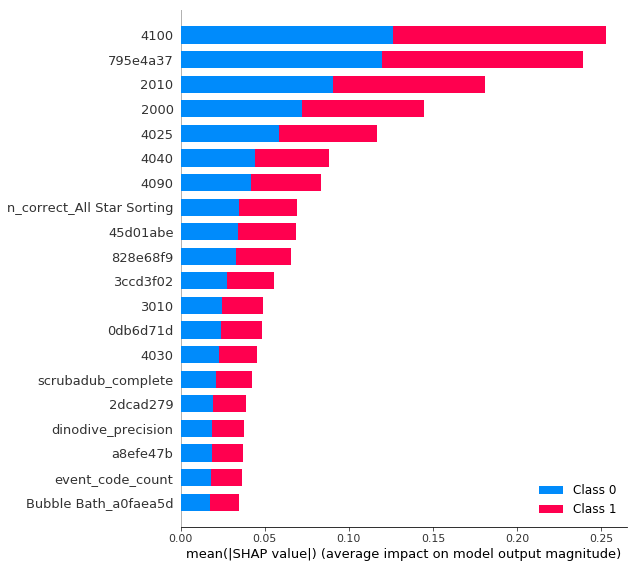

In [26]:
with open("../dsb2019/models/regression_baseline_ass_params.json", "r") as f:
    validator_params=json.load(f)
selected_features = [f for f in train_features.columns if f not in ("installation_id", "game_session", "accuracy_group")]
validator = adv_validation.AdversarialValidator(validator_params, train_features, test_features, selected_features=selected_features,test_size=0.5)
validator.fit()
print(validator.roc_auc())
validator.shap_important_features()

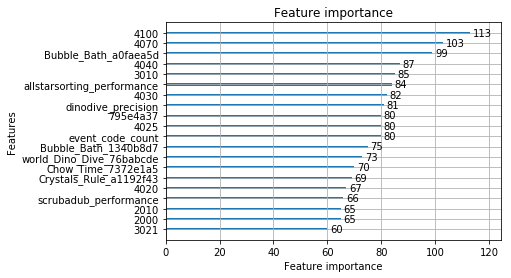

In [27]:
validator.lgb_important_features()

In [ ]:
subtrain_installations=pd.Series(train_features.installation_id.unique()).sample(frac=1., random_state=2019)
subtrain_features=train_features[train_features.installation_id.isin(subtrain_installations.values)].copy()
def check_hyperparams(params):
    print(params)
    if "max_depth" in params:
        params["max_depth"] = int(params["max_depth"])
    if "num_leaves" in params:
        params["num_leaves"] = int(params["num_leaves"])

    train_baseline_with_params = partial(train_baseline, params=params)
    cv=InstallationFold(n_splits=3)
    predictions = cross_validate(subtrain_features, subtrain_features.accuracy_group, make_features_wrapper, train_baseline_with_params, make_predictions,
                                cv=cv)
    return {
        "loss": np.mean([mean_squared_error(true, pred) for pred, true in predictions]),
        "status": STATUS_OK,
        "params": params
    }


def tune(check_params, n_tries=25, n_learning_rate_tries=15, learning_rate=None, n_estimators=10_000):        
    if learning_rate is None:
        learning_rate_space = {
            'learning_rate': hp.loguniform("learning_rate", np.log(0.005), np.log(0.3)),
            'metric': 'rmse',
            'objective': 'rmse',
            #'num_classes': 4,
            'random_state': 2019,
            "n_estimators": n_estimators,

        }
        trials = Trials()
        result = fmin(check_params,
                      learning_rate_space, tpe.suggest, n_learning_rate_tries, trials=trials)
        print(result)
        learning_rate = round(trials.best_trial["result"]["params"]["learning_rate"], 3)

    param_space = {
        'metric': 'rmse',
        'objective': 'rmse',
        #'num_classes': 4,
        'lambda_l1': hp.uniform("lamba_l1", 1e-10, 1),
        'lambda_l2': hp.uniform("lambda_l2", 1e-10, 1),
        'random_state': 2019,
        "n_estimators": n_estimators,
        "learning_rate": learning_rate,
        "max_depth": hp.quniform("max_depth", 2, 16, 1),
        "num_leaves": hp.choice("num_leaves", [3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095]),
        "subsample": hp.quniform("subsample", 0.01, 1, 0.01),
        "feature_fraction": hp.quniform("feature_fraction", 0.01, 1, 0.01),
    }

    trials = Trials()
    fmin(check_params,
         param_space, tpe.suggest, n_tries, trials=trials)
    best_params = trials.best_trial["result"]["params"]
    return best_params

In [ ]:
best_params=tune(check_hyperparams, n_tries=100, n_learning_rate_tries=10)

In [ ]:
best_params

What was selected on 100% of the data

```
{'feature_fraction': 0.53,
 'lambda_l1': 0.922950554822482,
 'lambda_l2': 0.835047934936944,
 'learning_rate': 0.006,
 'max_depth': 11,
 'metric': 'rmse',
 'n_estimators': 10000,
 'num_leaves': 31,
 'objective': 'rmse',
 'random_state': 2019,
 'subsample': 0.9500000000000001}

```

In [27]:
# best_params={'feature_fraction': 0.58,
#  'lambda_l1': 0.45619796864269707,
#  'lambda_l2': 0.033257384218246686,
#  'learning_rate': 0.007,
#  'max_depth': 14,
#  'metric': 'multiclass',
#  'n_estimators': 10000,
#  'num_classes': 4,
#  'num_leaves': 31,
#  'objective': 'multiclass',
#  'random_state': 2019,
#  'subsample': 0.9500000000000001}

In [ ]:
with open("../dsb2019/models/regression_baseline_ass_params.json", "w") as f:
    json.dump(best_params, f)

In [28]:
baseline_model=train_baseline(train_features.drop(["installation_id", "accuracy_group"], axis=1), train_features.accuracy_group.values, 
               params=best_params)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 2000 rounds
[100]	valid_0's rmse: 1.08462
[200]	valid_0's rmse: 1.02401
[300]	valid_0's rmse: 0.997718
[400]	valid_0's rmse: 0.985382
[500]	valid_0's rmse: 0.979624
[600]	valid_0's rmse: 0.976506
[700]	valid_0's rmse: 0.975185
[800]	valid_0's rmse: 0.974886
[900]	valid_0's rmse: 0.974637
[1000]	valid_0's rmse: 0.974814
[1100]	valid_0's rmse: 0.97459
[1200]	valid_0's rmse: 0.974513
[1300]	valid_0's rmse: 0.974426
[1400]	valid_0's rmse: 0.974613
[1500]	valid_0's rmse: 0.974874
[1600]	valid_0's rmse: 0.975217
[1700]	valid_0's rmse: 0.975491
[1800]	valid_0's rmse: 0.976023
[1900]	valid_0's rmse: 0.97656
[2000]	valid_0's rmse: 0.977143
[2100]	valid_0's rmse: 0.977714
[2200]	valid_0's rmse: 0.978081
[2300]	valid_0's rmse: 0.978419
[2400]	valid_0's rmse: 0.978911
[2500]	valid_0's rmse: 0.979495
[2600]	valid_0's rmse: 0.980047
[2700]	valid_0's rmse: 0.980481
[2800]	valid_0's rmse: 0.980973
[2900]	valid_0's rmse: 0.981537
[3000]	valid_0's rmse:

In [29]:
predictions = cross_validate(train_features, train_features.accuracy_group, make_features_wrapper, partial(train_baseline, params=best_params), 
                             make_predictions)
np.mean([mean_squared_error(true, pred) for pred, true in predictions]), [mean_squared_error(true, pred) for pred, true in predictions]

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 2000 rounds
[100]	valid_0's rmse: 1.09134
[200]	valid_0's rmse: 1.03224
[300]	valid_0's rmse: 1.00642
[400]	valid_0's rmse: 0.994038
[500]	valid_0's rmse: 0.988331
[600]	valid_0's rmse: 0.985854
[700]	valid_0's rmse: 0.984472
[800]	valid_0's rmse: 0.983866
[900]	valid_0's rmse: 0.983486
[1000]	valid_0's rmse: 0.983312
[1100]	valid_0's rmse: 0.982948
[1200]	valid_0's rmse: 0.983063
[1300]	valid_0's rmse: 0.983131
[1400]	valid_0's rmse: 0.983412
[1500]	valid_0's rmse: 0.983595
[1600]	valid_0's rmse: 0.983903
[1700]	valid_0's rmse: 0.984287
[1800]	valid_0's rmse: 0.984561
[1900]	valid_0's rmse: 0.984844
[2000]	valid_0's rmse: 0.985249
[2100]	valid_0's rmse: 0.985526
[2200]	valid_0's rmse: 0.985935
[2300]	valid_0's rmse: 0.986503
[2400]	valid_0's rmse: 0.986824
[2500]	valid_0's rmse: 0.987088
[2600]	valid_0's rmse: 0.987393
[2700]	valid_0's rmse: 0.987676
[2800]	valid_0's rmse: 0.988357
[2900]	valid_0's rmse: 0.988949
[3000]	valid_0's rmse

(0.9960614034505578,
 [0.9647463955228139,
  0.9979926126086378,
  0.9567602265050382,
  1.0106369948895797,
  1.0501707877267201])

In [30]:
baseline_model.save_model(str(MODELS_DIR / "regression_baseline_ass.lgb"))

In [31]:
features, target = make_features(train_features)
prediction=baseline_model.predict(features)
clf = ThresholdClassifier()
clf.fit(prediction, target)

100%|██████████| 1000/1000 [00:22<00:00, 43.67it/s, best loss: -0.7327517282153477]


ThresholdClassifier(n_iter=1000, random_state=2019)

In [32]:
clf.coef_

[1.133344256160828, 1.7435176549917584, 2.2370331184605807]